# Sharding Results

Here we will analyze the results from [Flower](https://github.com/adap/flower) simulations for convergence on various datasets

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
# Default
import os
import re
import collections

# File Utils
import glob

# Processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read Simulation data

In [31]:
def simulation_files(simulation_dir: str, ext: str):
    return glob.glob(f"{simulation_dir}/*.{ext}")

In [32]:
def parse_filename(pattern: str, filename: str, default: str):
    rs = re.search(pattern, filename)
    if rs:
        return rs.group(1) if rs.groups() else rs.group()
    return default

In [157]:
simulation_path = "../model"
ext = "output"

simulation_filenames = simulation_files(simulation_dir=simulation_path, ext=ext)
simulations = []
for filename in simulation_filenames:
    df_simulation = pd.read_csv(filename)

    df_simulation["epoch"] = df_simulation.index + 1
    df_simulation["file"] = os.path.basename(filename)
    df_simulation["method"] = df_simulation["file"].apply(lambda x: parse_filename(r"eval_([a-zA-Z0-9]+)_", x, "1"))
    df_simulation["B"] = df_simulation["file"].apply(lambda x: parse_filename(r"B(\d+)", x, "1"))
    df_simulation["E"] = df_simulation["file"].apply(lambda x: parse_filename(r"E(\d+)", x, "1"))
    simulations.append(df_simulation.apply(pd.to_numeric, errors="ignore"))

df_simulations = pd.concat(simulations).reset_index(drop=True)
df_simulations

,loss,accuracy,epoch,file,method,B,E
0,0.002843,0.9717,1,eval_SFL_B10_E15.output,SFL,10,15
1,0.002005,0.9834,2,eval_SFL_B10_E15.output,SFL,10,15
2,0.001704,0.9859,3,eval_SFL_B10_E15.output,SFL,10,15
3,0.001557,0.9869,4,eval_SFL_B10_E15.output,SFL,10,15
4,0.001479,0.9875,5,eval_SFL_B10_E15.output,SFL,10,15
...,...,...,...,...,...,...,...
175,0.006415,0.9404,11,eval_FAV_B10_E5.output,FAV,10,5
176,0.006045,0.9424,12,eval_FAV_B10_E5.output,FAV,10,5
177,0.005643,0.9476,13,eval_FAV_B10_E5.output,FAV,10,5
178,0.005372,0.9491,14,eval_FAV_B10_E5.output,FAV,10,5


In [147]:
method_map = collections.defaultdict(lambda: "UNKNOWN", **{
    "SFL": "ScaleSFL",
    "FAV": "FedAvg"
})

## Model Accuracy 

In [148]:
# Plot theming
sns.set_theme("paper")

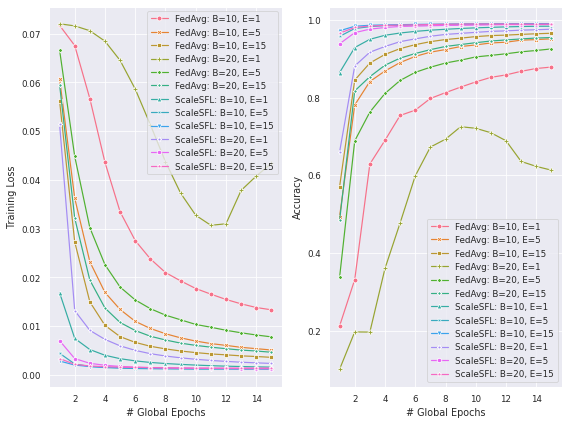

In [158]:
df_data = df_simulations[df_simulations.method.str.len() > 1].sort_values(by=["method", "B", "E"])
legend = (
    df_data.groupby("file")
    .head(1)
    .sort_values(by=["method", "B", "E"])
    .apply(lambda x: f"{method_map[x['method']]}: B={x['B']}, E={x['E']}", axis=1)
)
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
ax = sns.lineplot(
    data=df_data, 
    x="epoch", 
    y="loss", 
    hue="file",  
    style="file", 
    markers=True, dashes=False,
    # legend=legend.tolist(), 
    # palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[0]
)
ax.set(xlabel="# Global Epochs", ylabel="Training Loss")
ax.legend(labels=legend)
ax = sns.lineplot(
    data=df_data, 
    x="epoch", 
    y="accuracy", 
    hue="file",  
    style="file", 
    markers=True, dashes=False,
    # legend=legend.tolist(), 
    # palette=sns.color_palette("hls", as_cmap=True),
    ax=axs[1]
)
ax.set(xlabel="# Global Epochs", ylabel="Accuracy")
ax.legend(labels=legend)
fig.tight_layout()
ax.get_figure().savefig("model-performance.png", dpi=300)